# Unsupervised cross-domain image generation

- Given two related domains, S and T, it can build a generative function G that maps an input sample from S to the domain T

- Produce face emoji that are visually appealing and capture much more of the facial characteristics than the emoji created by well-trained human annotators who use the conventional tools.

## Resource

- paper: https://arxiv.org/abs/1611.02200
- code: https://github.com/yunjey/domain-transfer-network

## Architecture

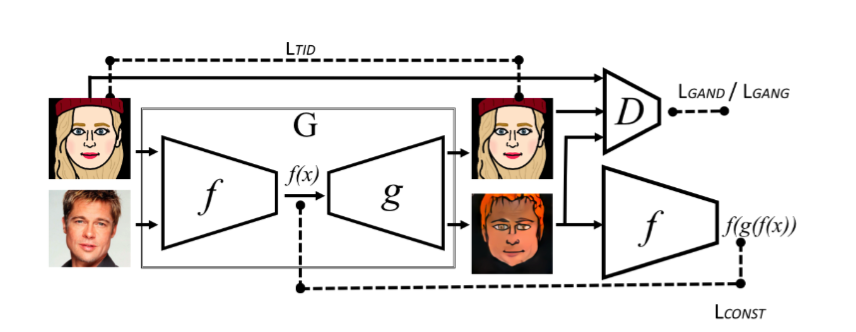

## Formulation

### Discriminator's Loss

$L_{D}= - E_{x\in s}logD_{1}(g(f(x))) - E_{x\in t}logD_{2}(G(f(x))) - E_{x \in t}logD_{3}(x)$

- s and t are pdf
- $D_1 , D_2$ Estimate conversions within the same domain or across domains
- $D_3$ is a traditional discriminator, which evaluates the authenticity of images (are they real or generated)

### Generator's Loss

$L_{G} = L_{GANG} + \alpha L_{CONST} + \beta L_{TID} + \gamma L_{TV}$

$L_{GANG} = - E_{x \in s}logD_{3}(g(f(x))) - E_{x \in t}logD_{3}(g(f(x)))$

$L_{CONST} = \sum_{x \in s} d(f(x),f(g(f(x))))$

$L_{TID}=\sum_{x \in t} d_{2}(x,G(x))$

- $L_G$ Total loss for generator.
- $L_{GANG}$ is the adversarial loss for the generator.
- $L_{CONST}$ represents a consistency loss. It measures the distance between the feature representation of the original input and the output.
- $L_{TID}$ is target identity Loss, it measures the distance between the target sample and its generated version.
- $L_{TV}$ is a regularization loss.
- $d , d_2$ is $L_2$ Normal.

## Implementation

### Download the data

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.layers import Resizing

In [8]:
!cd /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data

### Load svhn data

In [10]:
!mkdir -p mnist
!mkdir -p svhn

!wget -O svhn/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -O svhn/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget -O svhn/extra_32x32.mat http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

--2024-06-05 14:01:29--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘svhn/train_32x32.mat’

svhn/train_32x32.ma 100%[===================>] 173.61M  3.27MB/s    in 74s     

2024-06-05 14:02:44 (2.34 MB/s) - ‘svhn/train_32x32.mat’ saved [182040794/182040794]

--2024-06-05 14:02:44--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘svhn/test_32x32.mat’

svhn/test_32x32.mat 100%[===================>]  61.30M  3.74MB/s    in 21s     

2024-06-05 14:03:05 (2.99 MB/s) - ‘svhn/test_32x32.mat

### Load Mnist data and resize

In [17]:
# Specify the path to save the MNIST data
data_dir = '/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/mnist'

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Resize the images from 28x28 to 32x32
resize_layer = Resizing(32, 32, interpolation='bilinear')

# Expand the dimensions of the images to add a channel dimension (grayscale)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Apply the resize operation to training and test images
train_images_resized = resize_layer(train_images)
test_images_resized = resize_layer(test_images)

# Normalize the images to [0, 1]
train_images_resized = train_images_resized / 255.0
test_images_resized = test_images_resized / 255.0

# Save as pickle
with open(f'{data_dir}/mnist_train.pkl', 'wb') as f:
    pickle.dump((train_images_resized, train_labels), f)
with open(f'{data_dir}/mnist_test.pkl', 'wb') as f:
    pickle.dump((test_images_resized, test_labels), f)

#### Padding = 'same'
- **'same' padding** means that the input tensor is padded in such a way that the output tensor has the same height and width as the input tensor.
- Padding is added equally to both sides of the input. If the kernel size is even, extra padding may be added to the bottom and right sides.
- This is useful when you want the output to have the same spatial dimensions as the input.

#### Padding = 'valid'
- **'valid' padding** means no padding is added to the input tensor. The convolution is only applied to valid positions where the entire filter fits inside the input dimensions.
- This results in an output tensor that is smaller than the input tensor, depending on the filter size and stride.
- This is useful when you want to reduce the spatial dimensions of the output.

#### Calculation of Output Shape

##### Same Padding:
For a given input dimension \(I\), kernel size \(K\), stride \(S\), and padding \(P\), the output dimension \(O\) is calculated as:
$ O = \left\lceil \frac{I}{S} \right\rceil $

##### Valid Padding:
For the same parameters, the output dimension \(O\) is calculated as:
$ O = \left\lfloor \frac{I - K + 1}{S} \right\rfloor $

#### Example Calculations:

##### Same Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lceil \frac{32}{1} \right\rceil = 32 $

##### Valid Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lfloor \frac{32 - 3 + 1}{1} \right\rfloor = 30 $


In [26]:
# Define the Content Extractor
# input 32*32*3
# output 4*4*128
def content_extractor(inputs, training=False):
    # Down sampling layer with 64 3*3 filters.
    # padding = same, the input tensor = output tensor.
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation=tf.nn.tanh, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    
    return x

In [27]:
# Define the Generator
# input 4*4*128
# output 28*28*1
def generator(inputs, training=False):
    # Conv2DTranspose is know as upsampling layer, it 512 4 * 4 filters.
    # padding = valid, no padding is add to the input tensor.
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=1, padding='valid', activation=None, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation=tf.nn.tanh, use_bias=False)(x)
    
    return x

In [28]:
# Define the Discriminator
# input 28*28*1
# output 16 dimension vector
def discriminator(inputs, training=False):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=tf.nn.relu, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, (4, 4), strides=1, padding='valid', activation=None, use_bias=False)(x)
    x = tf.keras.layers.Flatten()(x)
    
    return x

In [33]:
# Define the DTN model
def build_dtn_model(mode='train'):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    
    # content tensor 4*4*128
    content = content_extractor(inputs, training=(mode == 'train' or mode == 'pretrain'))
    # print(content.shape)
    
    if mode == 'pretrain':
        logits = content
        return tf.keras.Model(inputs, logits)
    
    generated = generator(content, training=(mode == 'train'))
    
    if mode == 'train':
        logits = discriminator(generated, training=True)
        return tf.keras.Model(inputs, [logits, generated])
    else:
        logits = discriminator(inputs, training=False)
        return tf.keras.Model(inputs, logits)

In [35]:
# Instantiate and test the model in 'train' mode
model = build_dtn_model(mode='train')
model.summary()

# Create example input
input_shape = (1, 32, 32, 3)  # Example input shape for a batch size of 1
dummy_input = tf.random.normal(input_shape)
output = model(dummy_input)
print("Output shape:", [o.shape for o in output])

(None, 4, 4, 128)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 16, 16, 64)        1728      
                                                                 
 batch_normalization_100 (B  (None, 16, 16, 64)        256       
 atchNormalization)                                              
                                                                 
 re_lu_80 (ReLU)             (None, 16, 16, 64)        0         
                                                                 
 conv2d_81 (Conv2D)          (None, 8, 8, 128)         73728     
                                                                 
 batch_normalization_101 (B  (None, 8, 8, 128)         512       
 atchNormalization)                      